## 1. Project Goal

The objective of this project is to build a robust and efficient deep learning model that can accurately predict demographic attributes—specifically, age, gender, and race—based solely on facial images. By leveraging the EfficientNetB0 architecture, this model aims to provide a balanced trade-off between accuracy and computational efficiency, making it suitable for applications in various real-world scenarios, such as targeted marketing, demographic studies, and social research. The predicted attributes are valuable for enhancing personalization, supporting diversity research, and gaining insights into the distribution of demographic traits in visual datasets.

To train the model, the project utilizes a UTKFace dataset containing labeled facial images, where each label is embedded in the file name, formatted as [age]_[gender]_[race]_[date&time].jpg. Here:

- [age] is represented by an integer from 0 to 116, indicating the age of the individual.
- [gender] is denoted by 0 for male and 1 for female.
- [race] is represented by an integer from 0 to 4, indicating categories as follows: White, Black, Asian, Indian, and Others (such as Hispanic, Latino, and Middle Eastern).
- [date&time] is formatted as yyyymmddHHMMSSFFF, providing the timestamp of when the image was collected for UTKFace

Using this structured data, the project aims to build a model that accurately predicts each attribute, advancing the application of deep learning in demographic analysis.

## 2. Data Collection

In [1]:
import os
import re
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from PIL import Image
import cv2
import pickle
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber

In [2]:
# Add path dir and regular expression to parse the filename
dataset_path ='../data'
pattern = r"(\d+)_(\d)_(\d)_(\d+).jpg"

# Define image and batch size 
image_size = (224, 224)
batch_size = 32

# Function to parse the label from the filename
def parse_label(filename):
    match = re.match(pattern, filename)
    if match:
        age = int(match.group(1))
        gender = int(match.group(2))
        race = int(match.group(3))
        return age, gender, race
    else:
        raise ValueError(f"Filename {filename} does not match the format")

## 3. Data Preparation

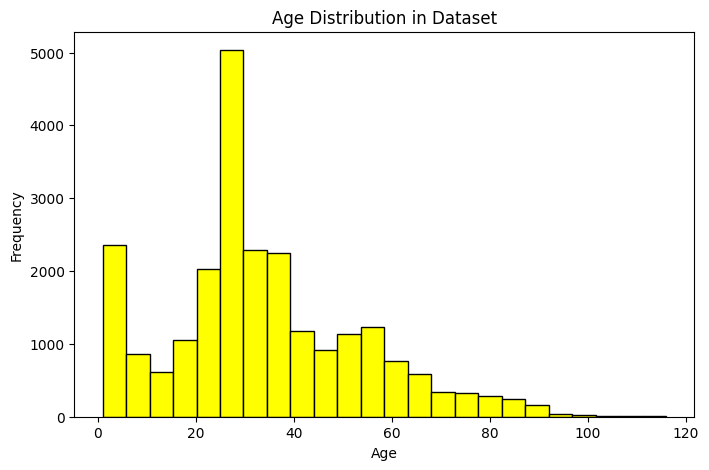

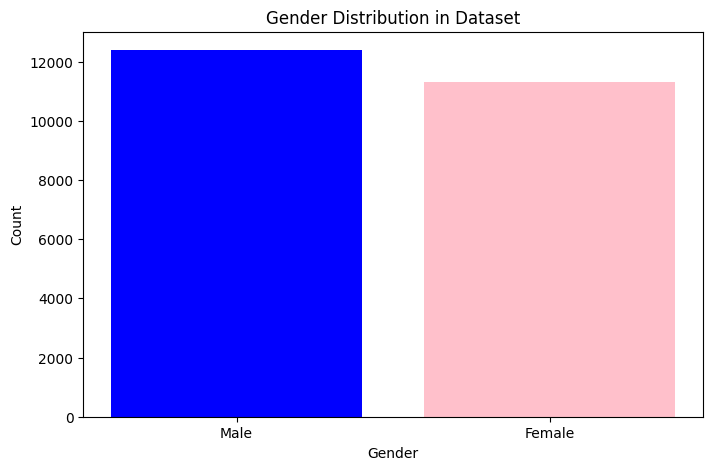

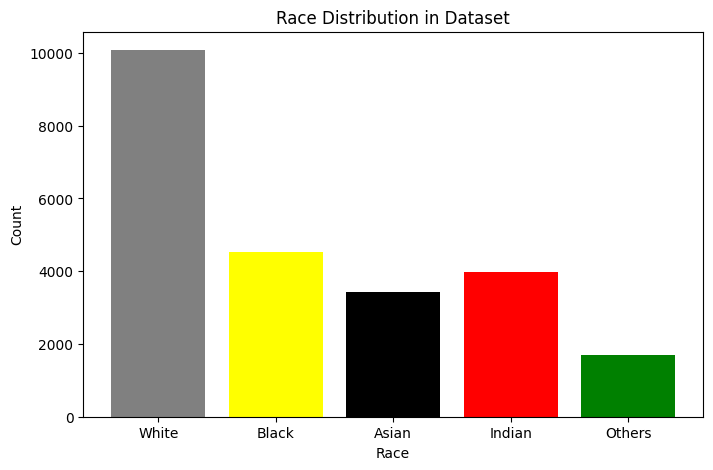

In [3]:
# Display plot class distribution each label 
def plot_distribution(files):
    ages = [parse_label(os.path.basename(f))[0] for f in files]  # Umur
    genders = [parse_label(os.path.basename(f))[1] for f in files]  # Gender
    races = [parse_label(os.path.basename(f))[2] for f in files]  # Race

    plt.figure(figsize=(8, 5))
    plt.hist(ages, bins=24, color='yellow', edgecolor='black')
    plt.title('Age Distribution in Dataset')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8, 5))
    gender_counts = Counter(genders)
    plt.bar(gender_counts.keys(), gender_counts.values(), color=['blue', 'pink'])
    plt.xticks([0, 1], ['Male', 'Female'])
    plt.title('Gender Distribution in Dataset')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(8, 5))
    race_counts = Counter(races)
    plt.bar(race_counts.keys(), race_counts.values(), color=['gray', 'black', 'yellow', 'red', 'green'])
    plt.xticks([0, 1, 2, 3, 4], ['White', 'Black', 'Asian', 'Indian', 'Others'])
    plt.title('Race Distribution in Dataset')
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.show()

all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.jpg')]

plot_distribution(all_files)

The histogram above shows an uneven age distribution within the dataset, with a significant skew toward certain age groups, particularly around the 20-year age range. This imbalance in age representation can lead to a biased model that performs well on overrepresented age groups but poorly on underrepresented ones. To address this issue, a stratified downsampling approach is required to ensure that each age group is proportionally represented, maintaining the overall structure of the dataset while reducing the dominance of overrepresented classes. This process results in a more balanced dataset, which can lead to a model that generalizes better across different age groups.

The histogram of age distribution highlights a strong imbalance, with certain age groups, especially around 20 years, being heavily overrepresented. Such skewed distribution can bias the model towards these age groups, affecting its ability to generalize well across other age ranges. To address this, a stratified downsampling approach is implemented. This approach not only downsamples based on age intervals but also ensures a balanced representation of races within each age bin. Specifically, it samples the majority "White" race proportionally along with non-White groups in each age interval. By considering both age and race during downsampling, this method maintains diversity across demographic categories, fostering a more balanced dataset that can improve the model's predictive accuracy across age and race attributes.

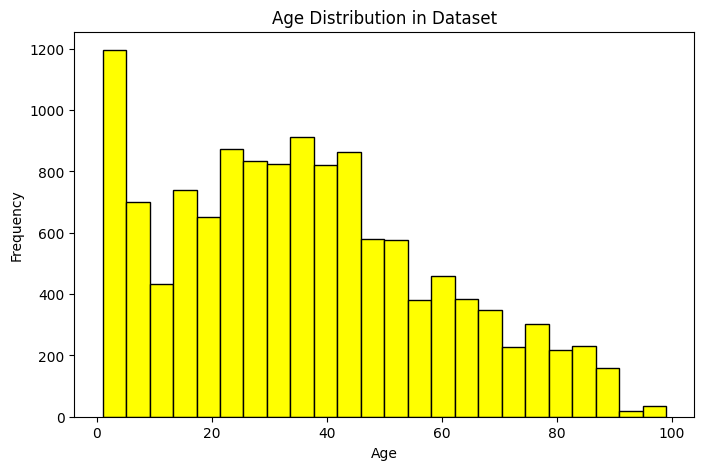

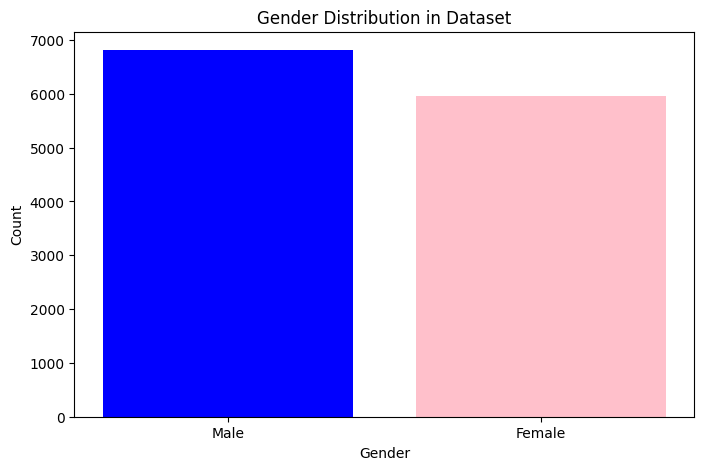

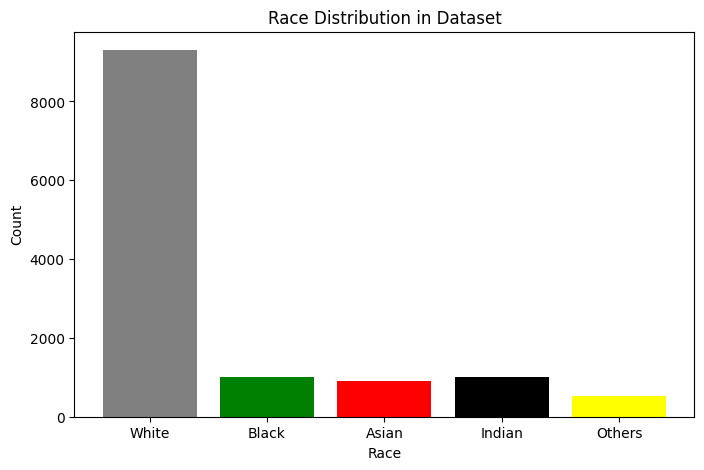

In [4]:
# Stratified downsampling based on age with consideration of race
def stratified_downsampled(files, age_bins, target_per_bin=1000):
    race_white = 0 
    age_to_files = {i: [] for i in range(len(age_bins) - 1)}

    for f in files:
        age, _, race = parse_label(os.path.basename(f))
        for i in range(len(age_bins) - 1):
            if age_bins[i] <= age < age_bins[i + 1]:
                age_to_files[i].append((f, race))
                break

    selected_files = []
    for age_bin_idx, age_bin_files in age_to_files.items():
        if len(age_bin_files) > target_per_bin:
            white_files = [f for f, race in age_bin_files if race == race_white]
            non_white_files = [f for f, race in age_bin_files if race != race_white]

            if len(white_files) > target_per_bin:
                selected_files.extend(random.sample(white_files, target_per_bin))
            else:
                selected_files.extend(white_files)
                remaining_needed = target_per_bin - len(white_files)
                selected_files.extend(random.sample(non_white_files, remaining_needed))
        else:
            selected_files.extend([f for f, _ in age_bin_files])

    return selected_files

age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

downsampled_files = stratified_downsampled(all_files, age_bins, target_per_bin=1000)

plot_distribution(downsampled_files)

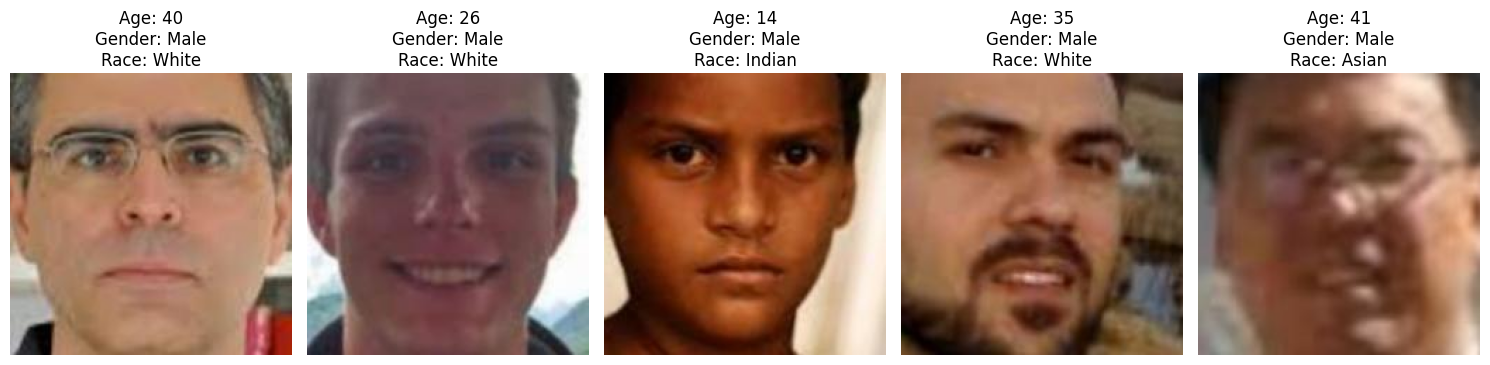

In [5]:
# Convert gender and race to string labels
def convert_labels(age, gender, race):
    gender_label = "Male" if gender == 0 else "Female"
    race_dict = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}
    race_label = race_dict.get(race, "Unknown")
    return age, gender_label, race_label

random_files = random.sample(downsampled_files, 5)

plt.figure(figsize=(15, 10))

for i, file_name in enumerate(random_files):
    img_path = file_name  
    img = Image.open(img_path)

    base_name = os.path.basename(file_name)
    age, gender, race = parse_label(base_name)
    age, gender_label, race_label = convert_labels(age, gender, race)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Age: {age}\nGender: {gender_label}\nRace: {race_label}")

plt.tight_layout()
plt.show()

## 4. Preprocessing & Splitting

In [6]:
# Function to load image and label
def load_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = preprocess_input(image)
    
    age, gender, race = label
    return image, (age, gender, race)

# Function to create a dataset from image files
def create_dataset(image_files):
    labels = [parse_label(os.path.basename(file)) for file in image_files]
    ages = tf.constant([label[0] for label in labels], dtype=tf.int32)
    genders = tf.constant([label[1] for label in labels], dtype=tf.int32)
    races = tf.constant([label[2] for label in labels], dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((image_files, (ages, genders, races)))
    dataset = dataset.map(lambda x, y: (load_image(x, y)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [7]:
# Get all image files
total_files = len(downsampled_files)

# Shuffle files with a consistent seed
seed = 42
random.seed(seed)
random.shuffle(downsampled_files)

# Split the data into train, validation, and test
train_split = 0.5
val_split = 0.25
test_split = 0.25

train_count = int(total_files * train_split)
val_count = int(total_files * val_split)

train_files = downsampled_files[:train_count]
val_files = downsampled_files[train_count:train_count + val_count]
test_files = downsampled_files[train_count + val_count:]

# Create dataset for each subset
train_ds = create_dataset(train_files)
val_ds = create_dataset(val_files)
test_ds = create_dataset(test_files)

## 5. Exploratory Data Analysis

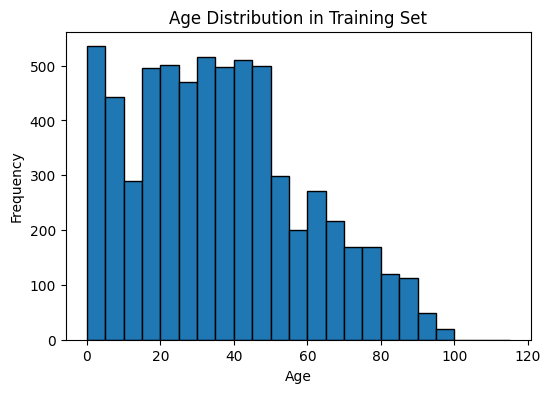

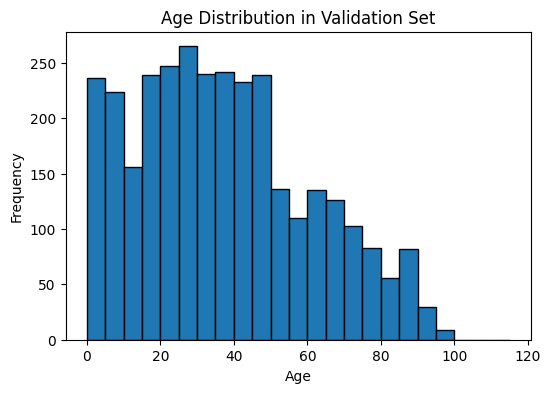

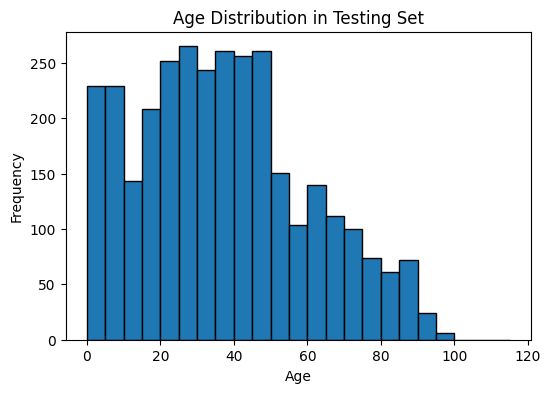

In [8]:
# Plot the age distribution each subset data after split
def plot_age_distribution(dataset, subset_name):
    ages = []
    for _, (age_labels, _, _) in dataset:
        ages.extend(age_labels.numpy())
    
    plt.figure(figsize=(6, 4))
    plt.hist(ages, bins=range(0, 120, 5), edgecolor='black')
    plt.title(f"Age Distribution in {subset_name} Set")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.show()

# Plot age distributions for training, validation, and test sets
plot_age_distribution(train_ds, "Training")
plot_age_distribution(val_ds, "Validation")
plot_age_distribution(test_ds, "Testing")

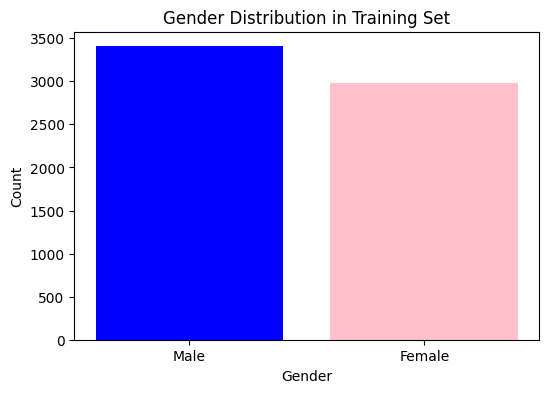

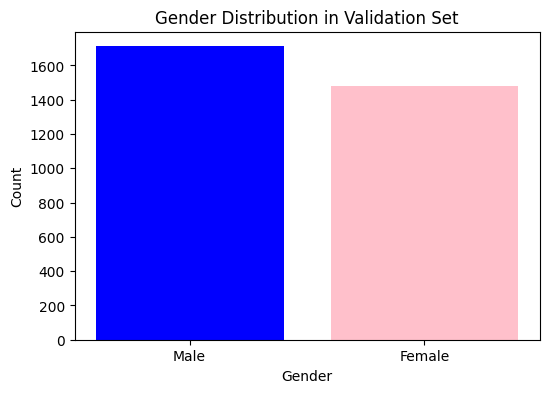

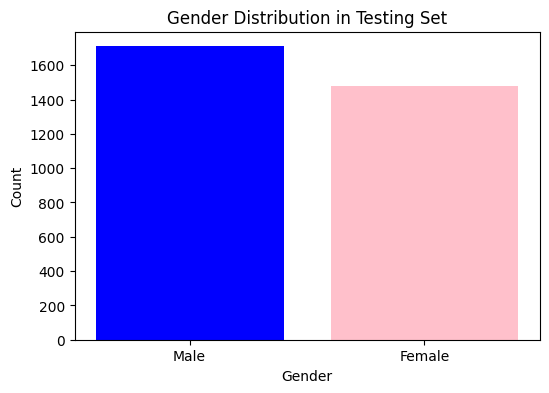

In [9]:
# Plot the gender distribution each subset data after split
def plot_gender_distribution(dataset, subset_name):
    gender_count = {0: 0, 1: 0}
    for _, (_, gender_labels, _) in dataset:
        unique, counts = np.unique(gender_labels.numpy(), return_counts=True)
        for u, c in zip(unique, counts):
            gender_count[u] += c
    
    plt.figure(figsize=(6, 4))
    plt.bar(['Male', 'Female'], [gender_count[0], gender_count[1]], color=['blue', 'pink'])
    plt.title(f"Gender Distribution in {subset_name} Set")
    plt.xlabel("Gender")
    plt.ylabel("Count")
    plt.show()

# Plot gender distributions for training, validation, and test sets
plot_gender_distribution(train_ds, "Training")
plot_gender_distribution(val_ds, "Validation")
plot_gender_distribution(test_ds, "Testing")

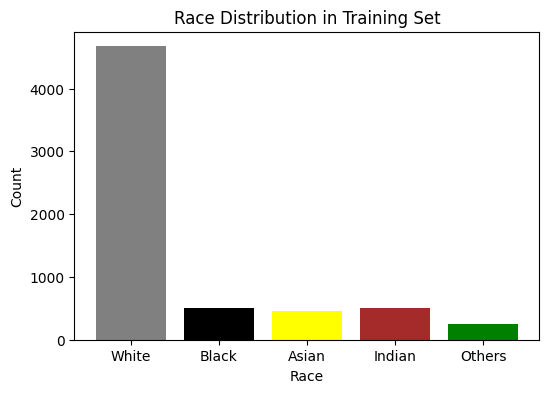

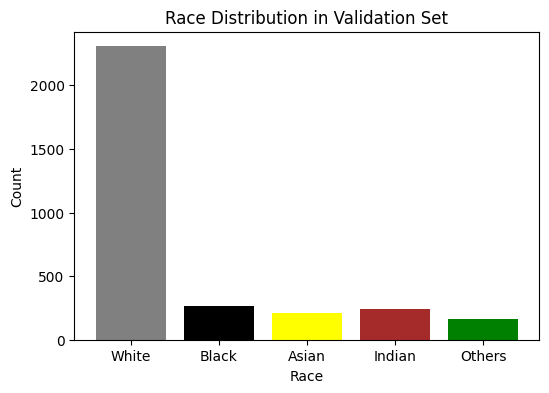

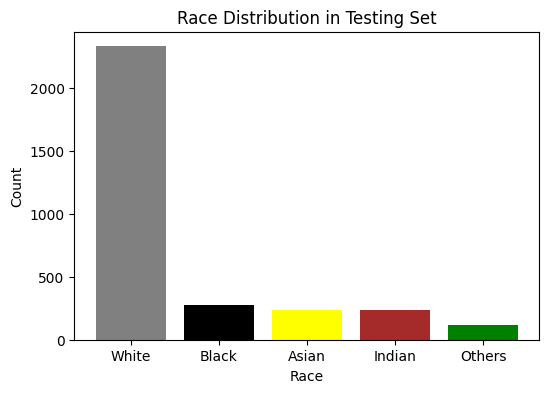

In [10]:
# Plot the race distribution each subset data after split
def plot_race_distribution(dataset, subset_name):
    race_count = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    for _, (_, _, race_labels) in dataset:
        unique, counts = np.unique(race_labels.numpy(), return_counts=True)
        for u, c in zip(unique, counts):
            race_count[u] += c
    
    plt.figure(figsize=(6, 4))
    plt.bar(['White', 'Black', 'Asian', 'Indian', 'Others'], 
            [race_count[i] for i in range(5)], color=['gray', 'black', 'yellow', 'brown', 'green'])
    plt.title(f"Race Distribution in {subset_name} Set")
    plt.xlabel("Race")
    plt.ylabel("Count")
    plt.show()

# Plot race distributions for training, validation, and test sets
plot_race_distribution(train_ds, "Training")
plot_race_distribution(val_ds, "Validation")
plot_race_distribution(test_ds, "Testing")

## 6. Model Development

In [11]:
# Create Model using MobileNetV2
input_shape = (224, 224, 3)

# Load the pretrained EfficientNetB0 model with imagenet weights and exclude the top layers
base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

In [12]:
# Freeze all layers except 'block_16' and the last 3 layers (Conv_1, Conv_1_bn, out_relu)
for layer in base_model.layers:
    if 'block7a' in layer.name or 'top_conv' in layer.name or 'top_bn' in layer.name or 'top_activation' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
# Add new classification layers
inputs = tf.keras.Input(shape=input_shape)

# Pass through the MobileNetV2 base model
x = base_model(inputs, training=False)

# Add global average pooling layer
x = layers.GlobalAveragePooling2D()(x)

# Dense layers dengan L2 regularization dan Batch Normalization
dense_age = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
bn_age = layers.BatchNormalization()(dense_age)
dropout_age = layers.Dropout(0.5)(bn_age)
age = layers.Dense(1, activation='relu', name='age')(dropout_age)

dense_gender = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
bn_gender = layers.BatchNormalization()(dense_gender)
dropout_gender = layers.Dropout(0.5)(bn_gender)
gender = layers.Dense(1, activation='sigmoid', name='gender')(dropout_gender)

dense_race = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
bn_race = layers.BatchNormalization()(dense_race)
dropout_race = layers.Dropout(0.5)(bn_race)
race = layers.Dense(5, activation='softmax', name='race')(dropout_race)

# Final Model with multiple outputs
model = Model(inputs=inputs, outputs=[age, gender, race])

## 7. Model Training

In [14]:
# Compile the model
huber_loss = Huber()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={'age': huber_loss, 'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy'},
    metrics={'age': 'mae', 'gender': 'accuracy', 'race': 'accuracy'}
)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnetb0[0][0]']         
 alAveragePooling2D)                                                                              
                                                                                              

In [16]:
# Reduce learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,          
    patience=3,            
    min_lr=1e-6            
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,          
    restore_best_weights=True 
)

In [17]:
# Model fitting
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/50
200/200 [==============================] - 906s 4s/step - loss: 28.1336 - age_loss: 23.0340 - gender_loss: 0.4299 - race_loss: 1.1880 - age_mae: 23.5310 - gender_accuracy: 0.8103 - race_accuracy: 0.6140 - val_loss: 16.9034 - val_age_loss: 13.2844 - val_gender_loss: 0.5135 - val_race_loss: 1.5701 - val_age_mae: 13.7780 - val_gender_accuracy: 0.7791 - val_race_accuracy: 0.4538 - lr: 0.0010
Epoch 2/50
200/200 [==============================] - 876s 4s/step - loss: 13.9538 - age_loss: 11.7921 - gender_loss: 0.3636 - race_loss: 0.7686 - age_mae: 12.2841 - gender_accuracy: 0.8433 - race_accuracy: 0.7526 - val_loss: 17.5238 - val_age_loss: 15.4286 - val_gender_loss: 0.3254 - val_race_loss: 1.0592 - val_age_mae: 15.9255 - val_gender_accuracy: 0.8471 - val_race_accuracy: 0.5945 - lr: 0.0010
Epoch 3/50
200/200 [==============================] - 870s 4s/step - loss: 11.1672 - age_loss: 9.6088 - gender_loss: 0.3110 - race_loss: 0.6857 - age_mae: 10.1015 - gender_accuracy: 0.8665 - race_

The training stopped at epoch 29 because the early stopping callback, configured with a patience of 10, detected no improvement in validation loss over the last 10 epochs (from epoch 20 to 29). This lack of improvement triggered early stopping to prevent overfitting, allowing the model to maintain optimal performance without completing the full 50 epochs

## 8. Model Evaluation

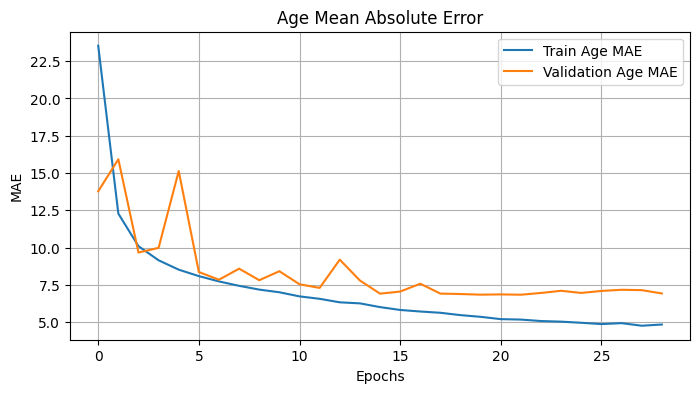

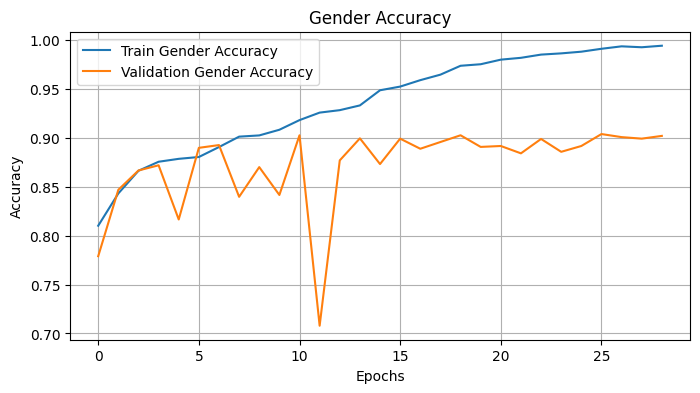

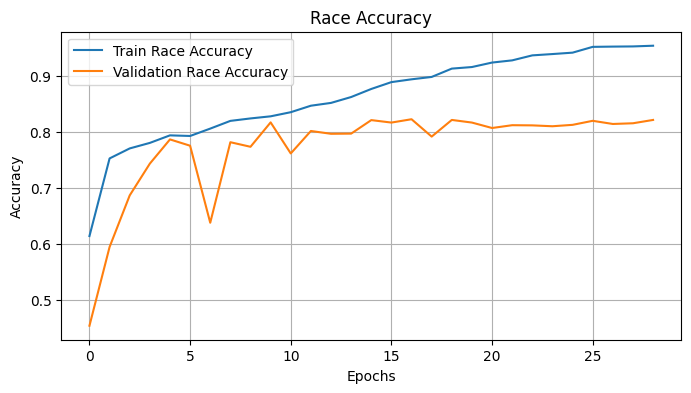

In [18]:
# Plot evaluation metrics for age, gender, and race
plt.figure(figsize=(8, 4))
plt.plot(history.history['age_mae'], label='Train Age MAE')
plt.plot(history.history['val_age_mae'], label='Validation Age MAE')
plt.title('Age Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['gender_accuracy'], label='Train Gender Accuracy')
plt.plot(history.history['val_gender_accuracy'], label='Validation Gender Accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['race_accuracy'], label='Train Race Accuracy')
plt.plot(history.history['val_race_accuracy'], label='Validation Race Accuracy')
plt.title('Race Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [19]:
# Evaluate on the test dataset
test_loss, test_age_loss, test_gender_loss, test_race_loss, test_age_mae, test_gender_accuracy, test_race_accuracy = model.evaluate(test_ds)
print('Test Gender Accuracy:', test_gender_accuracy)
print('Test Race Accuracy:', test_race_accuracy)
print('Test Age MAE:', test_age_mae)

100/100 [==============================] - 261s 3s/step - loss: 7.4905 - age_loss: 6.4423 - gender_loss: 0.3434 - race_loss: 0.5875 - age_mae: 6.9254 - gender_accuracy: 0.8976 - race_accuracy: 0.8355
Test Gender Accuracy: 0.8975563645362854
Test Race Accuracy: 0.8355262875556946
Test Age MAE: 6.925394058227539



The model evaluation results show that the deep learning model performed with an accuracy of 89.76% in predicting gender and 83.55% in predicting race, demonstrating strong classification capabilities for these attributes. For age prediction, the model achieved a Mean Absolute Error (MAE) of 6.93, indicating the average deviation between predicted and actual ages. While classification tasks (gender and race) achieved high accuracy, the model's age prediction suggests moderate performance, with some room for improvement in reducing the prediction error.

## 9. Model Deployment

In [21]:
# Save model efficientnet h5 and history pickle 
with open('../models/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
model.save('../models/efficientnet_b0.h5')
model.save('../models/efficientnet_b0')

INFO:tensorflow:Assets written to: ../models/efficientnet_b0\assets


INFO:tensorflow:Assets written to: ../models/efficientnet_b0\assets


1/1 [==============================] - 0s 441ms/step


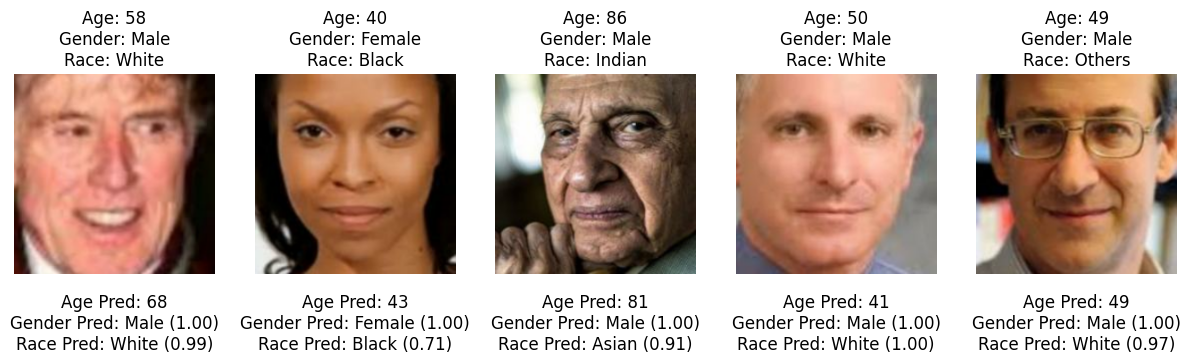

In [46]:
# Show preview image with true label and prediction from data test 
for images, labels in test_ds.take(1):
    batch_size = images.shape[0]
    num_images = 5  
    selected_indices = random.sample(range(batch_size), num_images)
    selected_images = tf.gather(images, selected_indices)
    
    ages = tf.gather(labels[0], selected_indices)
    genders = tf.gather(labels[1], selected_indices)
    races = tf.gather(labels[2], selected_indices)

    predictions = model.predict(selected_images)
    pred_ages = predictions[0].flatten()
    pred_genders = predictions[1].flatten()
    pred_races = predictions[2].argmax(axis=1)
    pred_race_confidences = predictions[2].max(axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        true_age = ages[i].numpy()
        true_gender = 'Male' if genders[i].numpy() == 0 else 'Female'
        true_race = ['White', 'Black', 'Asian', 'Indian', 'Others'][races[i].numpy()]

        pred_age = int(pred_ages[i])
        pred_gender = 'Male' if pred_genders[i] < 0.5 else 'Female'
        gender_confidence = 1 - pred_genders[i] if pred_genders[i] < 0.5 else pred_genders[i]
        pred_race = ['White', 'Black', 'Asian', 'Indian', 'Others'][pred_races[i]]
        race_confidence = pred_race_confidences[i]

        plt.subplot(1, num_images, i + 1)
        
        plt.imshow(selected_images[i].numpy().astype("uint8"))
        plt.title(f"Age: {true_age}\nGender: {true_gender}\nRace: {true_race}")
        plt.axis('off')  

        plt.text(0.5, -0.1, 
                 f"Age Pred: {pred_age}\nGender Pred: {pred_gender} ({gender_confidence:.2f})\nRace Pred: {pred_race} ({race_confidence:.2f})",
                 fontsize=12, ha='center', va='top', transform=plt.gca().transAxes)

    plt.show()

1/1 [==============================] - 0s 142ms/step


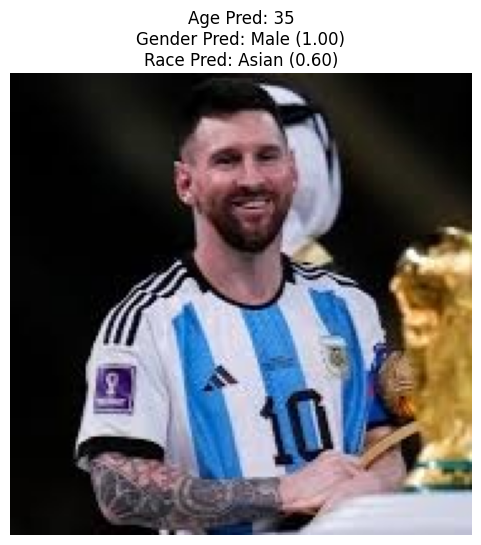

In [47]:
# Predict image from directory
def predict_and_display(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    image = tf.expand_dims(image, axis=0)  

    age_pred, gender_pred, race_pred = model.predict(image)
    age_pred = int(age_pred[0][0])
    
    raw_gender_pred = gender_pred[0][0] 
    gender_pred = "Male" if raw_gender_pred < 0.5 else "Female"
    gender_confidence = 1 - raw_gender_pred if gender_pred == "Male" else raw_gender_pred
    
    race_labels = ["White", "Black", "Asian", "Indian", "Others"]
    race_pred_label = race_labels[np.argmax(race_pred[0])]
    race_confidence = np.max(race_pred[0])

    # Load the original image for display
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Plotting the result
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.axis("off")
    plt.title(f"Age Pred: {age_pred}\nGender Pred: {gender_pred} ({gender_confidence:.2f})\nRace Pred: {race_pred_label} ({race_confidence:.2f})")
    plt.show()

# Predict and display the result
predict_and_display('../asset/image_1.jpg')

The model’s predictions on the image of Lionel Messi celebrating his FIFA World Cup 2022 victory are partially accurate. The model correctly predicted Messi's age as 35, which aligns with his actual age at the time of the event. Additionally, it accurately classified his gender as male with high confidence. However, the model misclassified his race as Asian, with a confidence level of 0.60, which is incorrect as Messi is of White (Caucasian) descent. This misclassification suggests that the model may struggle with accurately predicting race for certain images, indicating an area for potential improvement in its race classification performance